**Data Assimialtion using GANs & AAEs For Fluid Problem** 

This notebook contains the workflow, development code and some results of the application of generative models to 2D turbulent fluid modelling completed as an independent research component of the M.Sc. degree in [Applied Computational Science and Engineering](https://www.imperial.ac.uk/earth-science/prosp-students/pg-courses/applied-computational-msc/) at Royal School of Mines at Imperial College London (ICL).

The project was part of the Applied Modelling and Computational Group @ ICL and was supervised by :
- Prof Christopher Pain
- Dr. Claire E. Heaney
- Vinicius Santos Silva 

This notebook is divided in sections that included data preprocessing tasks, core code body and results visualization. Part of this project is the forward prediciton of timelvels using both GAN and AAE. For more information about this and the rest of the work, here is a link to the report completed alongside this code devlopment. More details can also be found in the [github repository](https://github.com/acse-moj20/msc-irp)



Contact: Mustapha Jolaade, moj20@ic.ac.uk

September 02, 2021





In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

%matplotlib inline
import sys
import os
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import joblib
import time


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time
from collections import deque

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Processing Power and Available Memory

GPU Specs

In [3]:
# ******** GPU Specifications *************
# *****************************************

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('GPU info not found.')
else:
  print(gpu_info)
print('Num of available GPUs: ', len(tf.config.list_physical_devices('GPU')))

# ******** Allocated memmory *************
# ****************************************
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print()
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('You are using a high-RAM runtime!')

Fri Sep  3 09:48:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Utility Functions

In [102]:

def plot_obs_data(generated_inv_fwd, generated_inv_bwd, nnx, nny, obs_times=[], X_obs=[], grid_points=[]):

    obs_times_plot = [obs_times[idx] for idx in range(45) if idx%5==0]
    
    fig, ax = plt.subplots(figsize=[6, 10])
    ax.plot(obs_times_plot, generated_inv_fwd[:, nnx, nny], label='initial')
    ax.plot(obs_times_plot, generated_inv_bwd[:, nnx, nny], label='final')
    if len(X_obs):
      # X_obs_plot = np.array([X_obs[idx] for idx in range(45) if idx%5==0])
      if [nnx, nny] in grid_points:
          ax.plot(obs_times, X_obs[:, nnx, nny], 'o', label='Observed data')
      else:
          ax.plot([],[])
    ax.set_ylim(-0.005, 0.005)
    ax.set_xlabel('time')
    ax.set_ylabel('vorticity')
    plt.grid()
    plt.legend()
    plt.tight_layout() 

def calculate_error(data, prediction):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  assert(len(data)==len(prediction))
  abs_error = abs(data - prediction)
  perc_error = abs_error*100/abs(data)
  max_abs_error = np.max(abs_error)
  mean_abs_error = np.mean(abs_error)
  return max_abs_error, mean_abs_error


def plot_vortex(data, times, cols, rows=1, skips=1, c_bar=True, cmap='RdBu', sensor_loc=[]):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  fig, ax = plt.subplots(rows, cols, figsize=[5* cols, 20], constrained_layout=True)
  for i, step in enumerate(times):
    im = ax.flatten()[i].imshow(data[step], cmap=cmap)
    for sensor in sensor_loc:
     ax.flatten()[i].scatter(sensor[0], sensor[1], c='g', s=50)
    if c_bar:
      cbar = plt.colorbar(im, ax=ax.flatten()[i], shrink=0.15, pad=0.05, panchor=(0.0, 0.0))
    ax.flatten()[i].set_title('t = {}'.format(step*skips), y=1.05, 
                          fontsize=16, fontweight="bold")
   
  plt.show()



def plot_linevortex(data_dict, times, cols, rows=1, skips=1):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  # use a gray background
  fig, ax = plt.subplots(rows, cols, figsize=[5* cols, 9], sharey='all')
  
  for i, step in enumerate(times):
    #im = ax.flatten()[i].imshow(data[step], cmap=cmap)
    for label in data_dict:
      plot_data = data_dict[label]
      plot_data_1d = plot_data[step].reshape(-1, 1)
      line_plt = ax.flatten()[i].plot(plot_data_1d, label=label)
      
      # Plot max and min locations
      ax.flatten()[i].plot(np.where(plot_data_1d == np.amax(plot_data_1d))[0], 
               np.amax(plot_data_1d), "bo", label='Pos. vortex')
      ax.flatten()[i].plot(np.where(plot_data_1d == np.amin(plot_data_1d))[0], 
               np.amin(plot_data_1d), "ro", label='Neg. vortex')

    if i == 0:
      ax.flatten()[i].legend(loc='best', prop={'size':10})
      ax.flatten()[i].set_ylabel('Magnitude of vortices')
    ax.flatten()[i].set_title('t = {}'.format(step*skips), y=1.05, 
                          fontsize=16, fontweight="bold")
    fig.text(0.5, -0.04, '1D Spatial domain', fontdict={
        'weight': 'normal',
        'size': 14,}, ha='center')
    
    
  plt.show()

def concat_timesteps(X_train, ntimes, step, window_start, window_end, verbose=0):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  X_train_concat = []
  for start, end in zip(window_start, window_end):
    for i in range(start, end+step): 
      X_train_concat.append(X_train[i:i+ntimes*step:step])
      if verbose:
        print('sample starts from {} :'.format(i))
        for j in range(i, i+ntimes*step, step):
          print('{}'.format(j) , end=', ')
        print('\n')
  return np.array(X_train_concat)

def invert_data(X_data, flag=None):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  if flag=='3':
    X_scale_inverted = scaler3.inverse_transform(X_data)
    X_pca_inverted = pca3.inverse_transform(X_scale_inverted)
  else:
    X_scale_inverted = scaler.inverse_transform(X_data)
    X_pca_inverted = pca.inverse_transform(X_scale_inverted)
  return X_pca_inverted



def transform_data(X_data):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  X_pca = pca.fit_transform(X_data)
  X_pca_scaled = scaler.fit_transform(X_pca)
  return X_pca_scaled

## Load and prepare data

In [8]:
# ********* Data details ***********
# **********************************
mem_load = True
SAVE_DIR = 'drive/MyDrive/MSC_IRP/PredGAN/'

# spatial domain 
nx = 256 
ny = nx

# temporal domain
timestep = 50 

num_of_coeff = 292
ntimes = 7 # Consecutive times for the GAN
step = 5 # step between times

num_sensors = 25




### Load Compressed Trajectories v1200

In [25]:
if (mem_load):
  pca = joblib.load('drive/MyDrive/MSC_IRP/data/pca_rom1200_292.pkl')
  X_1d_pca = np.load('drive/MyDrive/MSC_IRP/data/pca_calc_vortex_1200.npy')
  scaler = joblib.load('drive/MyDrive/MSC_IRP/data/scaler_1200.pkl')
  
print('Number of snapshots: {}'.format(X_1d_pca.shape[0]))
X_1d_pca_scaled = scaler.fit_transform(X_1d_pca)
# np.allclose(X_1d_pca, scaler.inverse_transform((X_1d_pca_scaled)))

Number of snapshots: 60000


### Load Compressed Trajectories v300

In [24]:
if (mem_load):
  pca3 = joblib.load('drive/MyDrive/MSC_IRP/data/pca_rom300_292.pkl')
  X_1d_pca3= np.load('drive/MyDrive/MSC_IRP/data/pca_calc_vortex_300.npy')
  scaler3 = joblib.load('drive/MyDrive/MSC_IRP/data/scaler_300.pkl')
  
print('Number of snapshots: {}'.format(X_1d_pca3.shape[0]))
X_1d_pca_scaled3 = scaler3.fit_transform(X_1d_pca3)


Number of snapshots: 15000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


**CONFIG. SETTINGS**

In [6]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

SAVE_DIR = 'drive/MyDrive/MSC_IRP/PredGAN'

nx = 256
ny = 256
timestep = 50

mode = 'aae'
num_sensors = 0
if mode=='aae':
  num_sensors = 25

print ('Grid: {} x {}'.format(nx, ny))

## Config Settings
normalize = False # flag to normalize training data before PCA or not.
mem_load = True
num_of_coeff = 292

ntimes = 7 # Consecutive times for the GAN
step = 5 # step between times

g_lr = 1e-4
d_lr = 1e-4
num_examples_to_generate = 15
BATCH_SIZE = 125
latent_space = 300
# Seed and intitialization
seed = tf.random.normal([num_examples_to_generate, latent_space])

Grid: 256 x 256


In [ ]:
from sklearn.model_selection import train_test_split
X_train1d_pca_scaled = X_train1d_pca_scaled.reshape(-1, timestep, num_of_coeff)
X_train1d_pca_scaled, X_test1d_pca_scaled = train_test_split(X_train1d_pca_scaled, test_size=0.5, random_state=1)
print('Train data: ',X_train1d_pca_scaled.shape)
print('Test data: ', X_test1d_pca_scaled.shape)
X_train1d_pca_scaled = np.reshape(X_train1d_pca_scaled, (-1, num_of_coeff))
X_test1d_pca_scaled = np.reshape(X_test1d_pca_scaled, (-1, num_of_coeff))

# Data Assimilation GAN

## Load model

In [73]:
from tensorflow.keras.models import load_model
generator, discriminator = load_model(SAVE_DIR+'ganmodels/E3000/model_vE3000_64b_wgan_01_292_4500.h5').layers
np.random.seed(0)
tf.random.set_seed(0)

latent_size = 3000

## Time series Concatenation

In [26]:
# Time series Concantenation
sample_size = int(X_1d_pca_scaled.shape[0]/timestep) 
window_start = [(sample*timestep)for sample in range(sample_size)]
window_end = [(sample*timestep) - (ntimes*step) for sample in range(1, sample_size + 1)]
X_train_concat = concat_timesteps(X_1d_pca_scaled, ntimes, step, window_start, window_end)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], (num_of_coeff )*ntimes)



print(' Number of concatenated time series for training: ', X_train_concat.shape[0])
print('---------------')
print('Test output:')
print(X_train_concat.shape)
print(X_train_concat_flatten.shape)

 Number of concatenated time series for training:  24000
---------------
Test output:
(24000, 7, 292)
(24000, 2044)


In [27]:
# Version 300. No train test split

sample_size = int(X_1d_pca_scaled3.shape[0]/timestep) 
window_start = [(sample*timestep)for sample in range(sample_size)]
window_end = [(sample*timestep) - (ntimes*step) for sample in range(1, sample_size + 1)]
X_train_concat3 = concat_timesteps(X_1d_pca_scaled3, ntimes, step, window_start, window_end)
X_train_concat_flatten3 = X_train_concat3.reshape(X_train_concat3.shape[0], num_of_coeff*ntimes)
print(' Number of concatenated time series for training: ', X_train_concat3.shape[0])
print('---------------')
print('Test output:')
print(X_train_concat3.shape)
print(X_train_concat_flatten3.shape)

 Number of concatenated time series for training:  6000
---------------
Test output:
(6000, 7, 292)
(6000, 2044)


Testing dimensionality reduction

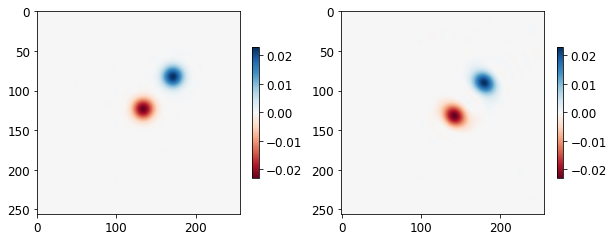

(7, 65536)


In [29]:
# Reverse transform concatenated series to check correctness

fig, ax = plt.subplots(1, 2, figsize=[10,10])
X_ = invert_data(X_train_concat3[0, :, :], flag='3')
im = ax[0].imshow(X_[0,:].reshape(nx, nx), cmap='RdBu')
im = ax[1].imshow(X_[1, :].reshape(nx, nx), cmap='RdBu')
fig.colorbar(im, ax=ax.flatten()[0], shrink=0.24, pad=0.05, panchor=(0.0, 0.0))
fig.colorbar(im, ax=ax.flatten()[1], shrink=0.24, pad=0.05, panchor=(0.0, 0.0))
plt.show()
print(X_.shape)


In [30]:

np.ptp(pca.components_)


0.04159145017823565

## Assimilate data with the GAN

In [75]:
data_range_ = tf.constant(scaler.data_range_, dtype=tf.float32)
data_min_ = tf.constant(scaler.data_min_, dtype=tf.float32)
components_ = tf.constant(pca.components_, dtype=tf.float32)
pca_mean_ = tf.constant(pca.mean_, dtype=tf.float32)

def pod_sse_loss(real_coding, gen_output):
    # -- POD coefficients --
    #
    # apply weights
    inp = tf.reshape(real_coding, [-1, codings_size])[:,:pca_size]*tf.math.sqrt(weight_pod)
    out = tf.reshape(gen_output, [-1, codings_size])[:,:pca_size]*tf.math.sqrt(weight_pod)
    
    pod_loss = tf.reduce_sum(tf.math.squared_difference(inp, out))
    return pod_loss

def obs_sse_loss(gen_output, obs_data, obs_points_inrange): 
    # -- Observed data --
    # 
    if obs_data.shape[0]>0:
        gen_output_scaled = ((tf.reshape(gen_output, [-1, codings_size])+1)/2)*data_range_ + data_min_  
        X_generated = tf.reshape(gen_output_scaled[:,:pca_size]@components_+pca_mean_, (len(gen_output_scaled), nx,nx))

        # get the data points
        sim_data = tf.gather_nd(X_generated, obs_points_inrange)
        
        obs_loss = tf.reduce_sum(tf.math.squared_difference(obs_data, sim_data))*weight_obs/tf.size(obs_data, out_type=tf.float32) 
    else:
        obs_loss = 0
        
    return obs_loss

def optimize_coding_forward_onlyPOD(latent_values, real_coding, obs_data, obs_points_inrange, epochs=1000):
    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    
    @tf.function
    def opt_step_forward(optimizer, latent_values, real_coding, obs_data, obs_points_inrange):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = generator(latent_values, training=False) 

            pod_loss = pod_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   
            obs_loss = obs_sse_loss(gen_output[:,:(ntimes - 1),:,:], obs_data, obs_points_inrange)
            loss = pod_loss 

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  

        return loss, pod_loss, obs_loss  
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step_forward(optimizer, latent_values, real_coding, obs_data, obs_points_inrange))
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output


def optimize_coding_forward(latent_values, real_coding, obs_data, obs_points_inrange, epochs=1000):
    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    
    @tf.function
    def opt_step_forward(optimizer, latent_values, real_coding, obs_data, obs_points_inrange):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = generator(latent_values, training=False) 

            pod_loss = pod_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   
            obs_loss = obs_sse_loss(gen_output[:,:(ntimes - 1),:,:], obs_data, obs_points_inrange)
            loss = pod_loss + obs_loss

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  

        return loss, pod_loss, obs_loss 
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step_forward(optimizer, latent_values, real_coding, obs_data, obs_points_inrange))
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output

def optimize_coding_backward(latent_values, real_coding, obs_data, obs_points_inrange, epochs=1000):
    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    #optimizer = tf.keras.optimizers.RMSprop(1e-3)
    
    @tf.function
    def opt_step_backward(optimizer, latent_values, real_coding, obs_data, obs_points_inrange):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = generator(latent_values, training=False) 

            pod_loss = pod_sse_loss(real_coding, gen_output[:,1:,:,:])     
            obs_loss = obs_sse_loss(gen_output[:,1:,:,:], obs_data, obs_points_inrange)
            loss = pod_loss + obs_loss

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  

        return loss, pod_loss, obs_loss 
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step_backward(optimizer, latent_values, real_coding, obs_data, obs_points_inrange))
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output


def process_obs_data(march_range, X_obs, obs_points):
    # Process the observed data to be in the range of the forward/backward march
    
    X_obs_inrange = X_obs[march_range]
    obs_points_inrange = np.array([x-np.array([march_range[0], 0, 0]) for x in obs_points if x[0] in march_range])
    if obs_points_inrange.size>0:
        obs_data = tf.gather_nd(X_obs_inrange, obs_points_inrange)
    else:
        obs_data = []

    obs_points_inrange = tf.constant(obs_points_inrange)
    obs_points_inrange = tf.cast(obs_points_inrange, dtype=tf.int32)
    obs_data = tf.constant(obs_data)
    obs_data = tf.cast(obs_data, dtype=tf.float32)
    
    return obs_data, obs_points_inrange

## Test case 1

### Generate data

X_obs.shape (50, 256, 256)


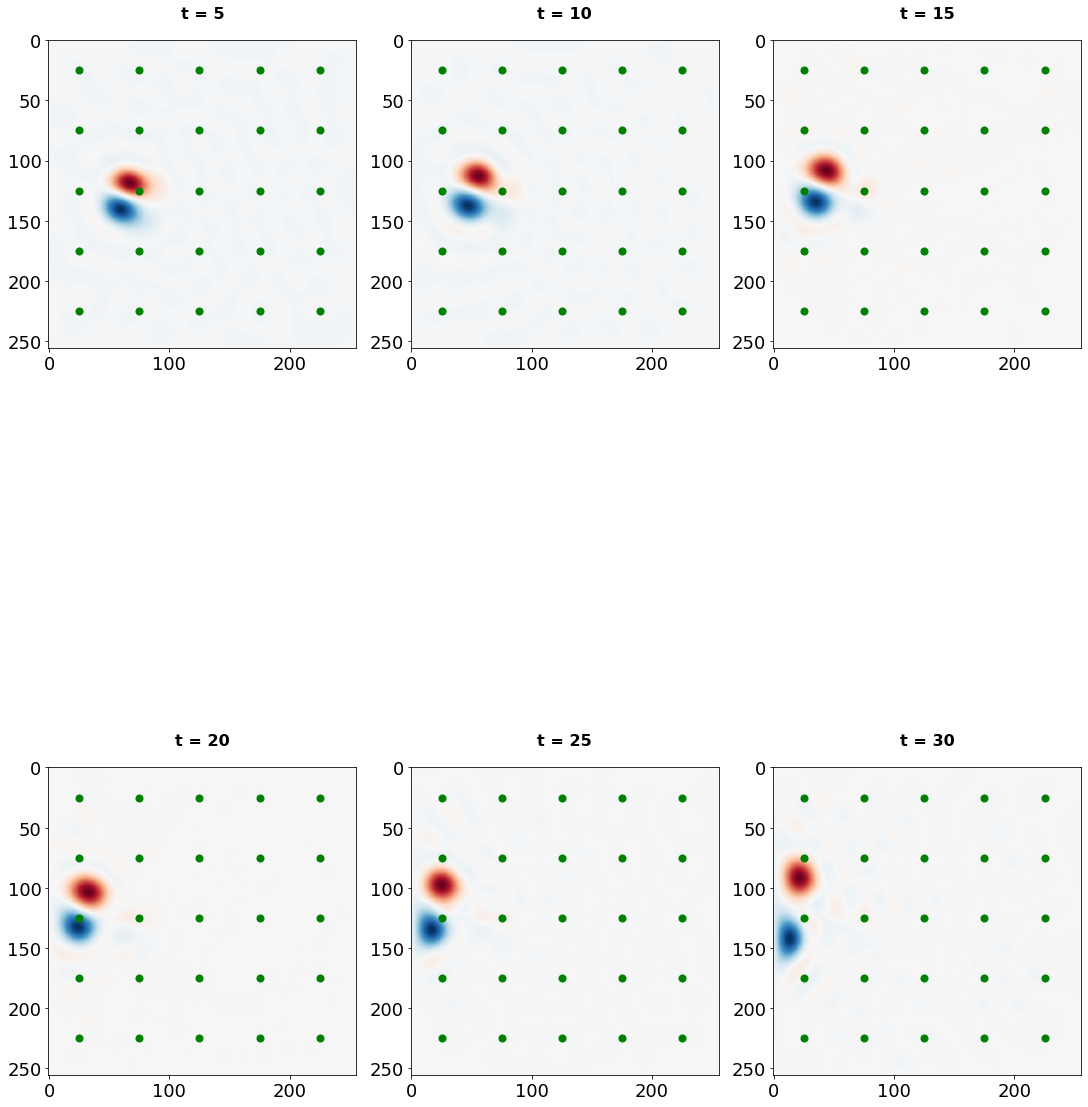

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]


In [122]:
# Obtain sensro data
# ------------------------

# snapshot index
n = int(4560 * 2.5)
X_obs = invert_data(X_1d_pca_scaled3[n:n+50], flag='3')
X_obs = X_obs.reshape(-1, nx, ny)

# Add noise
np.random.seed(0)
noise = 0.005
X_obs = X_obs + np.random.standard_normal(X_obs.shape)*noise*X_obs

# Times of X_obs to be considered for data assimilation
obs_times = list(range(0,len(X_obs[:])))
print('X_obs.shape', X_obs.shape)
# grid points: used to populate the obs_points
#[[nx, ny], 
# [nx, ny], 
# ...                 ]
grid_points = [
               [25,25],[25,75],[25,125],[25,175],[25, 225],
               [75,25],[75,75],[75,125],[75,175],[75, 225],
              [125,25],[125,75],[125,125],[125,175],[125, 225],
              [175,25],[175,75],[175,125],[175,175],[175, 225],
               [225,25],[225,75],[225,125],[225,175],[225, 225],
              ]
# obs_points:
#[[time,nx, ny], 
# [time, nx, ny], 
# ...                       ]
obs_points = []
for p in grid_points:
    for t in obs_times:
        obs_points.append([t]+p)
obs_points = np.array(obs_points)
times = [i for i in range(50) if i%5==0]
plot_vortex(X_obs,times[1:7], 3, 2, c_bar=False, sensor_loc=grid_points)
print(times)

In [129]:
forward_steps = 3 #length
time_steps = forward_steps + (ntimes-1)

# Calculate the weights
# Delta variables 
delta_obs = 0.4
delta_pod = 0.4

# POD coeficients
weight_pod = pca3.singular_values_/pca3.singular_values_.sum()
weight_pod = tf.constant(weight_pod, dtype=tf.float32)
print('weight_pod: ', weight_pod, end='\n\n')

# Observed data
weight_obs = 10.0*((delta_pod/delta_obs)**2)*ntimes
weight_obs = tf.constant(weight_obs, dtype=tf.float32)
print('weight_obs', weight_obs, end='\n\n')

weight_pod:  tf.Tensor(
[0.01998068 0.0190781  0.01722661 0.01621353 0.0151952  0.01490133
 0.01411944 0.01383351 0.01333104 0.01315979 0.01274764 0.01217587
 0.01189052 0.01155147 0.01143042 0.01113826 0.01107188 0.01075564
 0.01007281 0.00990733 0.00967857 0.00953933 0.00939713 0.00930975
 0.00891248 0.00881268 0.00858513 0.00847728 0.00845192 0.0082846
 0.00806871 0.0079527  0.00776311 0.00770336 0.0076436  0.00759383
 0.00735211 0.00726134 0.00715931 0.00712987 0.00695556 0.00667805
 0.00662139 0.00649369 0.00642652 0.00635431 0.00626026 0.00619856
 0.0061866  0.00613767 0.00601898 0.00587686 0.00582653 0.00569699
 0.00564877 0.00561474 0.00547861 0.00544116 0.00537404 0.00531688
 0.0052288  0.00517098 0.00513772 0.00497515 0.004929   0.0049059
 0.0048734  0.0047978  0.00473404 0.00467846 0.00455485 0.00453823
 0.00453487 0.00446293 0.00438577 0.00434121 0.00429271 0.00426361
 0.00424238 0.0041937  0.00403722 0.00402541 0.00396931 0.00391105
 0.00386488 0.00385657 0.00381036 0.0037


Iteration 0: forward and backward
-- Forward March --
Initial point losses: 
['1.86e-02', '1.86e-02', '2.11e-03']
['1.82e-02', '1.82e-02', '2.14e-03']
['2.91e-02', '2.91e-02', '2.10e-03']
['1.78e-02', '1.78e-02', '2.13e-03']
['1.90e-02', '1.90e-02', '2.16e-03']
['2.02e-02', '2.02e-02', '2.12e-03']
['2.04e-02', '2.04e-02', '2.11e-03']

Loss iteration 0: ['1.78e-02', '1.78e-02', '2.13e-03']
Loss iteration 1: ['9.50e-03', '9.50e-03', '1.90e-03'] - 27s
Loss iteration 2: ['6.72e-03', '6.72e-03', '1.63e-03'] - 28s
Loss iteration mean: ['1.13e-02', '1.13e-02', '1.89e-03']
-- Backward March --
Loss iteration 0: ['2.33e-03', '9.57e-04', '1.38e-03']
Loss iteration 1: ['2.63e-03', '1.03e-03', '1.60e-03'] - 31s
Loss iteration 2: ['2.78e-03', '9.13e-04', '1.87e-03'] - 31s
Loss iteration mean: ['2.58e-03', '9.66e-04', '1.61e-03']
Loss obs: 0.0017492087790742517

Iteration 1: forward and backward
-- Forward March --
Loss iteration 0: ['2.70e-03', '5.64e-04', '2.13e-03']
Loss iteration 1: ['2.50e-03'

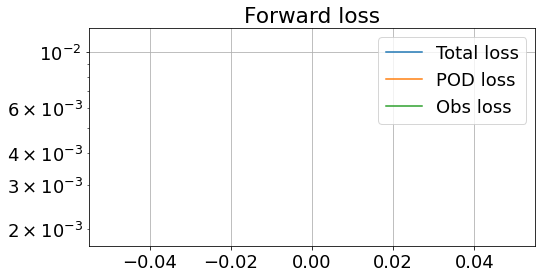

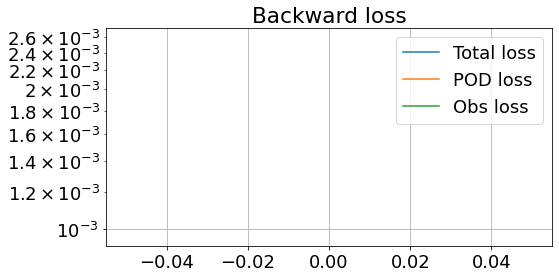

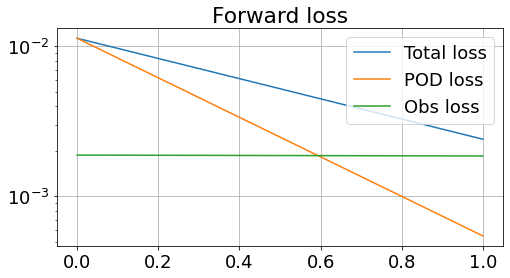

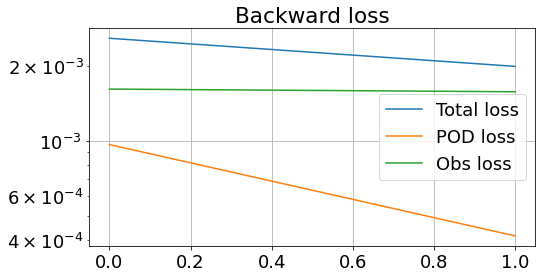

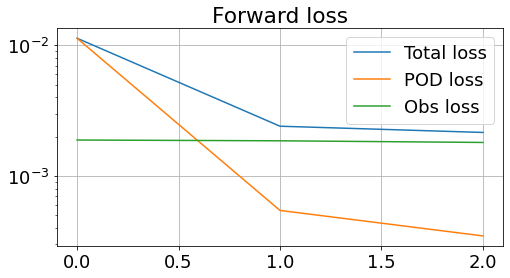

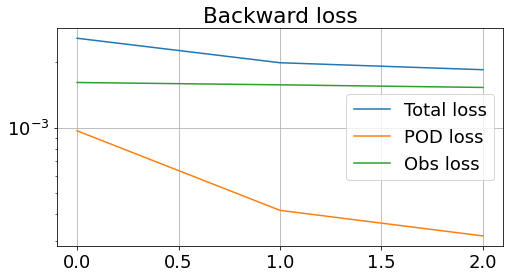

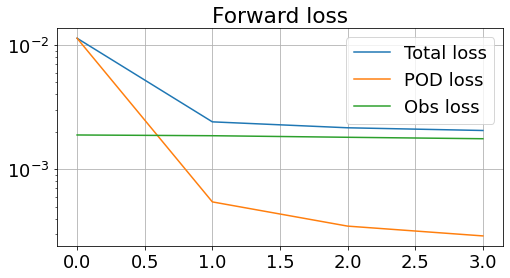

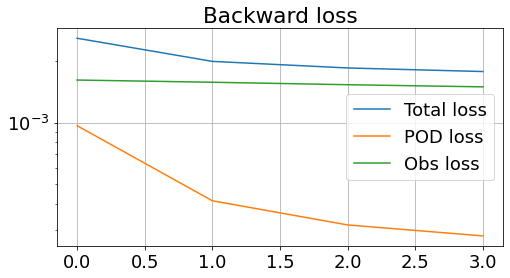

In [130]:
np.random.seed(0)
tf.random.set_seed(0)
n=0
list_X_predict_forward = []
list_X_predict_backward = []
list_relax = []

# Forward and backward march   
forward_loss = []
backward_loss = []
forward_onlyPOD_loss = []
relax = 1.0
codings_size = num_of_coeff
pca_size = num_of_coeff
for j in range(4):    
    print(f'\nIteration {j}: forward and backward')
    latent_values_forward = []
    latent_values_backward = []
    
    #===========================================
    # Forward march 
    #===========================================
    print('-- Forward March --')
    
    march_range = np.arange(0,(ntimes-1))

    obs_data, obs_points_inrange = process_obs_data(march_range, X_obs, obs_points)
    loss_iteration = []
    
    if j == 0: # If the first forward march
        # For the first forward march
        real_coding = X_train_concat3[n]
        real_coding = real_coding[:-1,:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        
        list_latent_values = []
        list_loss = []
        for _ in range(7):
            latent_values = tf.random.normal([1, latent_size])  
            latent_values = tf.Variable(latent_values) 
            latent_values, loss = optimize_coding_forward_onlyPOD(latent_values, real_coding, obs_data, obs_points_inrange, epochs=5000)
            list_latent_values.append(latent_values)
            list_loss.append(loss)

        latent_values = list_latent_values[np.argmin(list_loss,axis=0)[0]]
        loss_iteration.append(list(map(float,list_loss[np.argmin(list_loss,axis=0)[0]])))
        print('Initial point losses: ', end='\n')
        for l in list_loss:
            print(['{0:1.2e}'.format(float(x)) for x in l])
        print()
        print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in list_loss[np.argmin(list_loss,axis=0)[0]]]), end='\n')        

        latent_values_forward.append(latent_values.value())
        X_predict_forward = list(generator(latent_values).numpy().reshape(-1,codings_size))
        gen_predict = X_predict_forward[-1]

    else: # If not the first forward march
        real_coding = X_predict_backward[0:(ntimes-1),:].copy()
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)  
        
        latent_values, loss = optimize_coding_forward(latent_values, real_coding, obs_data, obs_points_inrange, epochs=5000)
        if j != 0:
            latent_values = tf.Variable((1-relax)*latent_values_forward_old[0] + relax*latent_values.value())
        loss_iteration.append(list(map(float,loss)))
        print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')
    
        latent_values_forward.append(latent_values.value())
        X_predict_forward = list(generator(latent_values).numpy().reshape(-1,codings_size))
        gen_predict = X_predict_forward[-1]

    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    
    for i in range(1, forward_steps): 
        march_range = np.arange(i,(ntimes-1)+i)
        obs_data, obs_points_inrange = process_obs_data(march_range, X_obs, obs_points)
        
        start = time.time()
        if j == 0:    
            latent_values, loss = optimize_coding_forward_onlyPOD(latent_values, real_coding, obs_data, obs_points_inrange, epochs=5000)
        
            loss_iteration.append(list(map(float,loss)))
            print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

            latent_values_forward.append(latent_values.value())
            gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[-1]
            X_predict_forward.append(gen_predict.copy())
     
        
        else:
            latent_values, loss = optimize_coding_forward(latent_values, real_coding, obs_data, obs_points_inrange, epochs=5000)
            latent_values = tf.Variable((1-relax)*latent_values_forward_old[i] + relax*latent_values.value())
        
            loss_iteration.append(list(map(float,loss)))
            print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

            latent_values_forward.append(latent_values.value())
            gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[-1]
            X_predict_forward.append(gen_predict.copy())

        real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        print ('{:.0f}s'.format( time.time()-start))
    X_predict_forward = np.array(X_predict_forward)
    if j == 0:
        X_predict_forward_first = X_predict_forward
    forward_loss.append(np.array(loss_iteration).mean(axis=0))
    print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])
    

    #===========================================
    # Backward march
    #===========================================
    print('-- Backward March --')
    
    march_range = np.arange(time_steps-(ntimes-1),time_steps)
    obs_data, obs_points_inrange = process_obs_data(march_range, X_obs, obs_points)    
    loss_iteration = []
    
    real_coding = X_predict_forward[time_steps-(ntimes-1):time_steps,:].copy()
    # if j ==0:
    #     real_coding[:,-2:] = R0s_run
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)  
    
    latent_values, loss = optimize_coding_backward(latent_values, real_coding, obs_data, obs_points_inrange, epochs=5000)
    if j != 0:
        latent_values = tf.Variable((1-relax)*latent_values_backward_old[0] + relax*latent_values.value())
    loss_iteration.append(list(map(float,loss)))
    print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')

    latent_values_backward.append(latent_values.value())
    X_predict_backward = deque(generator(latent_values).numpy().reshape(-1,codings_size))
    gen_predict = X_predict_backward[0]

    real_coding = np.concatenate((gen_predict.reshape(1,-1), real_coding), axis=0)[:-1,:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    
    for i in range(1, forward_steps): 
        march_range = np.arange(time_steps-(ntimes-1)-i,time_steps-i)
        obs_data, obs_points_inrange = process_obs_data(march_range, X_obs, obs_points)        
        
        start = time.time()
        latent_values, loss = optimize_coding_backward(latent_values, real_coding, obs_data, obs_points_inrange, epochs=5000)
        if j != 0:
            latent_values = tf.Variable((1-relax)*latent_values_backward_old[i] + relax*latent_values.value())
        loss_iteration.append(list(map(float,loss)))
        print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

        latent_values_backward.append(latent_values.value())
        gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[0]
        X_predict_backward.appendleft(gen_predict.copy())

        real_coding = np.concatenate((gen_predict.reshape(1,-1), real_coding), axis=0)[:-1,:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        print ('{:.0f}s'.format( time.time()-start))
    X_predict_backward = np.array(X_predict_backward)
    backward_loss.append(np.array(loss_iteration).mean(axis=0))
    print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])

    # Save relaxation
    list_relax.append(relax)
    
    # Update relaxation
    epison = 0
    loss_obs = (forward_loss[-1][-1] + backward_loss[-1][-1])/2 #obs loss from forward and backward march
    print(f'Loss obs: {loss_obs}')
    if j == 0:
        loss_obs_old = loss_obs        
        latent_values_forward_old = latent_values_forward.copy()
        latent_values_backward_old = latent_values_backward.copy()
        X_predict_backward_old = X_predict_backward.copy()
    else:
        print(f'Loss obs old: {loss_obs_old}')
        print(f'Relax old: {relax}, new ', end='')
        if (loss_obs - loss_obs_old) < epison:
            loss_obs_old = loss_obs
            X_predict_backward_old = X_predict_backward.copy()
            latent_values_forward_old = latent_values_forward.copy()
            latent_values_backward_old = latent_values_backward.copy()
            relax *= 1.5
            if relax > 1.0: 
                relax = 1.0              
        else:
            relax *= 0.5
            if relax < 0.01: 
                print(relax)
                print('Converged!')
                # plot loss functions
                fig, ax = plt.subplots(1,1, figsize=[8,4])
                ax.plot(np.arange(2,len(forward_loss)), forward_loss[2:])
                ax.set_title('Forward loss')
                #ax.set_yscale('log')
                #ax.set_ylim([0,20000])
                plt.grid()
                plt.legend(['Total loss','POD loss','Obs loss'])    
                fig, ax = plt.subplots(1,1, figsize=[8,4])
                ax.plot(np.arange(2,len(backward_loss)), backward_loss[2:])
                #ax.set_yscale('log')
                ax.set_title('Backward loss')
                #ax.set_ylim([0,20000])
                plt.grid()
                plt.legend(['Total loss','POD loss','Obs loss'])
                break
            X_predict_backward = X_predict_backward_old
            latent_values_forward = latent_values_forward_old
            latent_values_backward = latent_values_backward_old
        print(relax)
    
    
    list_X_predict_forward.append(X_predict_forward)
    list_X_predict_backward.append(X_predict_backward)

     #===============
    # Plots
    #===============   
    # plot loss function
    fig, ax = plt.subplots(1,1, figsize=[8,4])
    ax.plot(forward_loss)
    ax.set_title('Forward loss')
    ax.set_yscale('log')
    plt.grid()
    plt.legend(['Total loss','POD loss','Obs loss'])    
    fig, ax = plt.subplots(1,1, figsize=[8,4])
    ax.plot(backward_loss)
    ax.set_yscale('log')
    ax.set_title('Backward loss')
    plt.grid()
    plt.legend(['Total loss','POD loss', 'Obs loss'])
    
    # Plot forward and backward march   
    mpl.rcParams.update({'font.size': 18})
    mpl.rc('xtick', labelsize=18) 
    mpl.rc('ytick', labelsize=18) 
    mpl.rc('axes', labelsize=18)
    
    

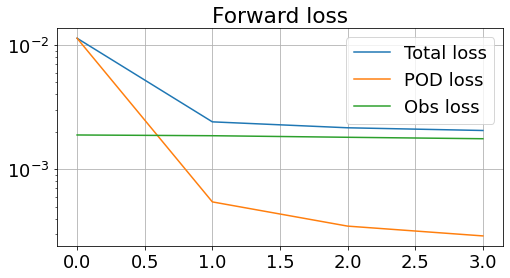

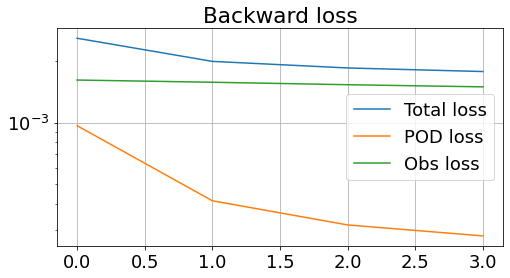

In [131]:
#===============
  # Plots
  #===============   
  # plot loss function
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(forward_loss)
ax.set_title('Forward loss')
ax.set_yscale('log')
plt.grid()
plt.legend(['Total loss','POD loss','Obs loss'])    
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(backward_loss)
ax.set_yscale('log')
ax.set_title('Backward loss')
plt.grid()
plt.legend(['Total loss','POD loss','Obs loss'])

# Plot forward and backward march   
mpl.rcParams.update({'font.size': 18})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)

  

-- Last time Stepping Forward March --
Loss iteration 0: ['2.47e-04', '2.47e-04', '2.02e-03']
Loss iteration 1: ['3.49e-04', '3.49e-04', '1.74e-03'] - 28s
Loss iteration 2: ['1.73e-04', '1.73e-04', '1.49e-03'] - 27s
Loss iteration mean: ['2.56e-04', '2.56e-04', '1.75e-03']


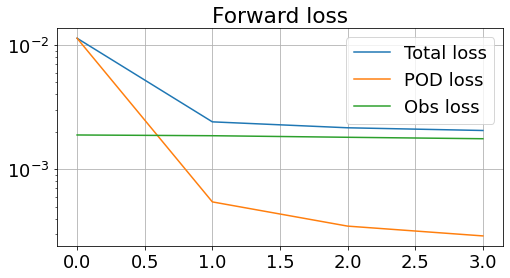

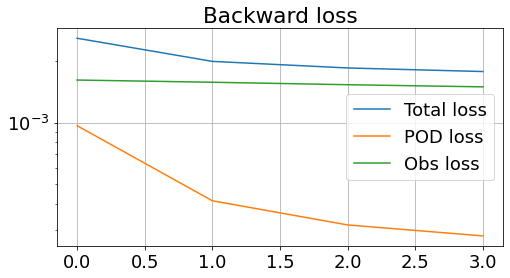

In [132]:
#===========================================
# Last time stepping forward march
#===========================================
print('-- Last time Stepping Forward March --')

march_range = np.arange(0,(ntimes-1))
obs_data, obs_points_inrange = process_obs_data(march_range, X_obs, obs_points)
loss_iteration = []

real_coding = X_predict_backward[0:(ntimes-1),:].copy()
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)  

latent_values_onlyPOD = tf.Variable(latent_values)
latent_values_onlyPOD, loss = optimize_coding_forward_onlyPOD(latent_values_onlyPOD, real_coding, obs_data, obs_points_inrange, epochs=5000)
loss_iteration.append(list(map(float,loss)))
print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')

X_predict_forward_last = list(generator(latent_values_onlyPOD).numpy().reshape(-1,codings_size))
gen_predict = X_predict_forward_last[-1]

real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(1, forward_steps): 
    march_range = np.arange(i,(ntimes-1)+i)
    obs_data, obs_points_inrange = process_obs_data(march_range, X_obs, obs_points)

    start = time.time()
    latent_values_onlyPOD, loss = optimize_coding_forward_onlyPOD(latent_values_onlyPOD, real_coding, obs_data, obs_points_inrange, epochs=5000)
    loss_iteration.append(list(map(float,loss)))
    print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

    gen_predict = generator(latent_values_onlyPOD).numpy().reshape(-1,codings_size)[-1]
    X_predict_forward_last.append(gen_predict.copy())

    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print ('{:.0f}s'.format( time.time()-start))
X_predict_forward_last = np.array(X_predict_forward_last)
forward_onlyPOD_loss.append(np.array(loss_iteration).mean(axis=0))
print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])


#===============
  # Plots
  #===============   
  # plot loss function
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(forward_loss)
ax.set_title('Forward loss')
ax.set_yscale('log')
plt.grid()
plt.legend(['Total loss','POD loss','Obs loss'])    
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(backward_loss)
ax.set_yscale('log')
ax.set_title('Backward loss')
plt.grid()
plt.legend(['Total loss','POD loss','Obs loss'])



X_obs.shape (50, 256, 256)


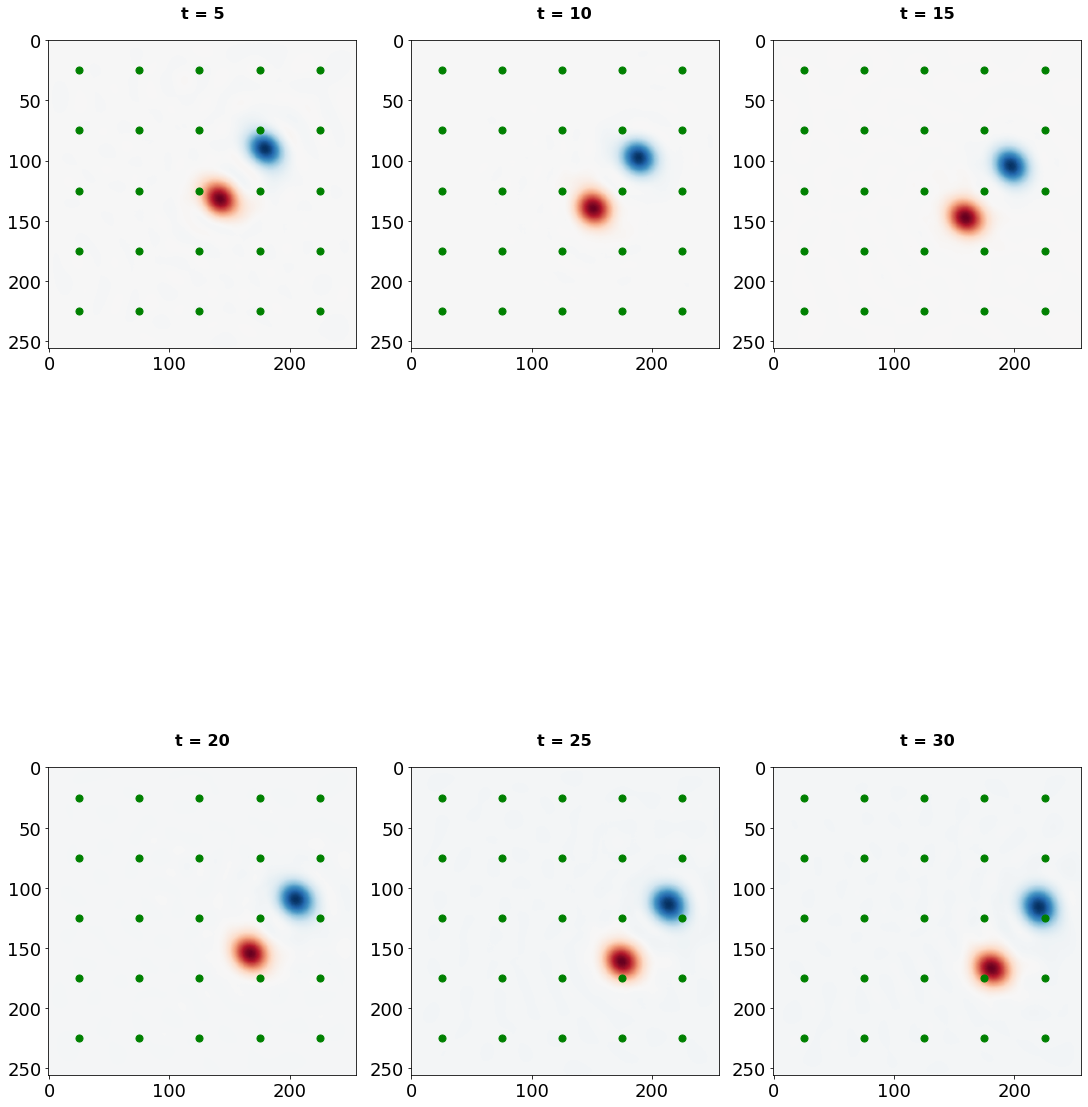

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]


In [125]:

n = int(0 * 2.5)
X_obs = invert_data(X_1d_pca_scaled3[n:n+50], flag='3')
X_obs = X_obs.reshape(-1, nx, ny)

# Add noise
np.random.seed(0)
noise = 0.005
X_obs = X_obs + np.random.standard_normal(X_obs.shape)*noise*X_obs

# Times of X_obs to be considered for data assimilation
obs_times = list(range(0,len(X_obs[:])))
print('X_obs.shape', X_obs.shape)
# grid points: used to populate the obs_points
#[[nx, ny], 
# [nx, ny], 
# ...                 ]
grid_points = [
               [25,25],[25,75],[25,125],[25,175],[25, 225],
               [75,25],[75,75],[75,125],[75,175],[75, 225],
              [125,25],[125,75],[125,125],[125,175],[125, 225],
              [175,25],[175,75],[175,125],[175,175],[175, 225],
               [225,25],[225,75],[225,125],[225,175],[225, 225],
              ]
# obs_points:
#[[time,nx, ny], 
# [time, nx, ny], 
# ...                       ]
obs_points = []
for p in grid_points:
    for t in obs_times:
        obs_points.append([t]+p)
obs_points = np.array(obs_points)
times = [i for i in range(50) if i%5==0]
plot_vortex(X_obs,times[1:7], 3, 2, c_bar=False, sensor_loc=grid_points)
print(times)

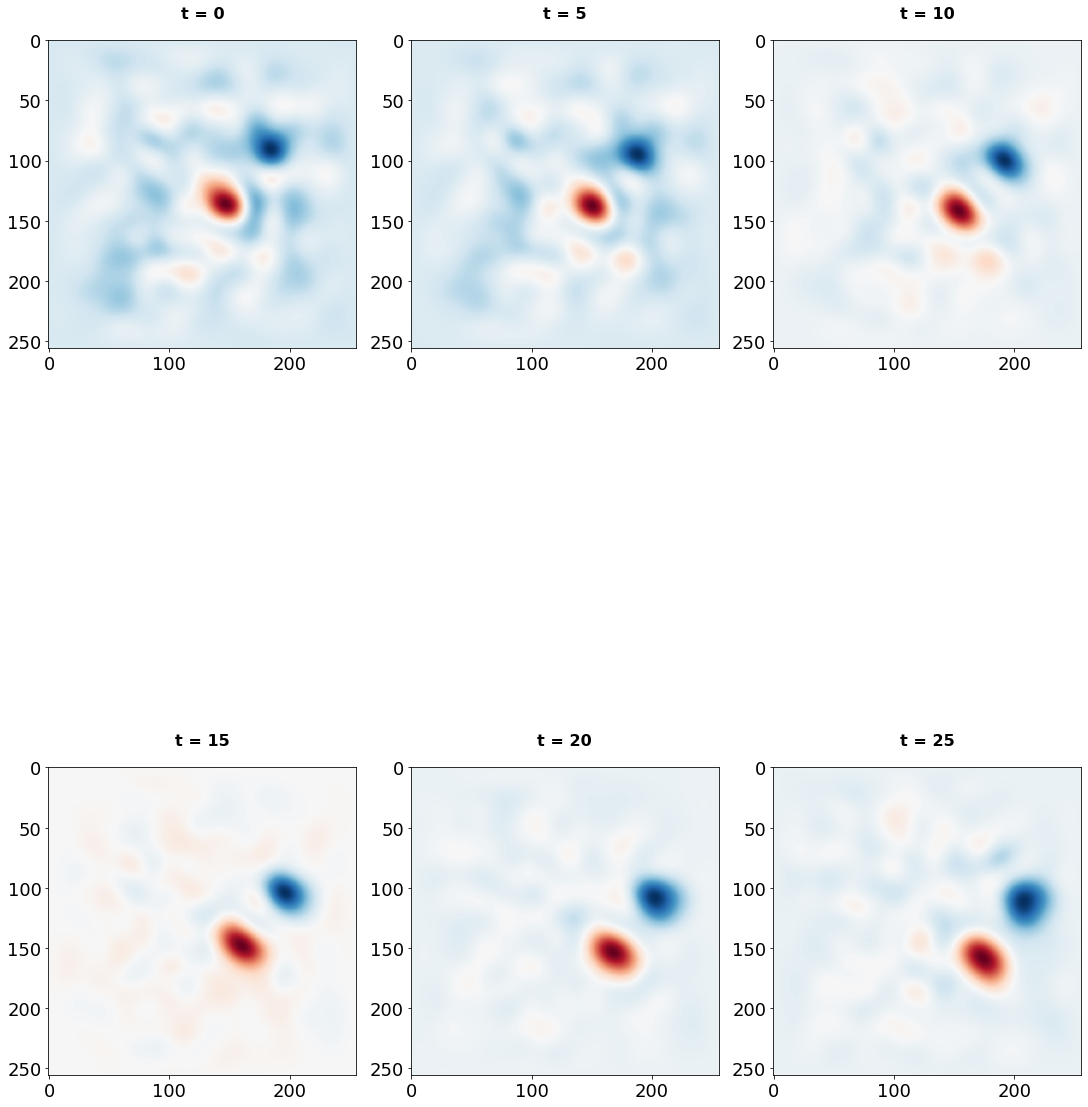

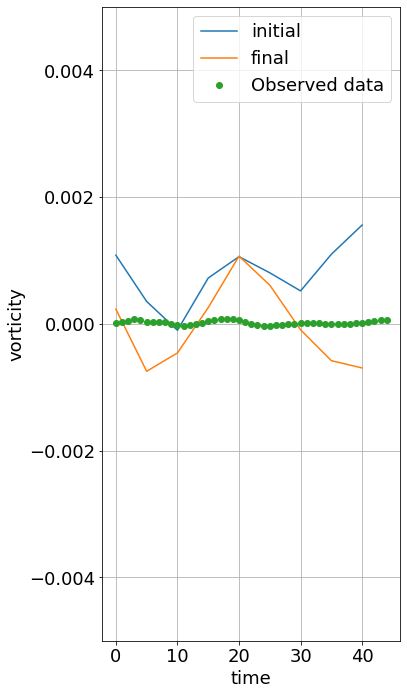

In [138]:
# Plot forward and backward march   
mpl.rcParams.update({'font.size': 18})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)

generated_forward = invert_data(X_predict_forward, flag='3').reshape(-1, nx, nx)
generated_backward = invert_data(X_predict_backward, flag='3').reshape(-1, nx, nx)
times = [i for i in range(len(X_predict_forward))]
plot_vortex(generated_forward[:6], times[:6], cols=3, rows=2, c_bar=False, skips = 5)

gen_X_predict_forward_first = invert_data(X_predict_forward_first, '3').reshape(-1, nx, nx)
gen_X_predict_forward_last = invert_data(X_predict_forward_last, '3').reshape(-1, nx, nx)

plot_obs_data(gen_X_predict_forward_first, gen_X_predict_forward_last, 25, 75, obs_times[:-5], X_obs[obs_times[:-5]], grid_points=grid_points)

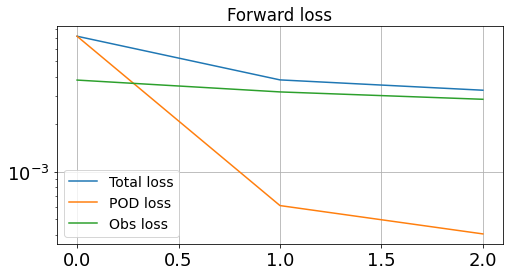

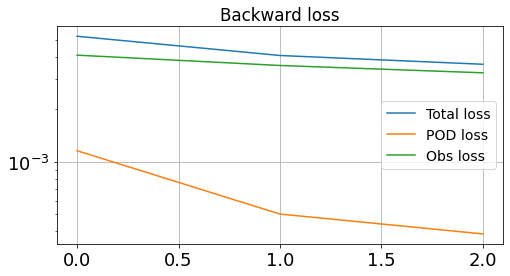

In [ ]:
# plot loss function 
mpl.rcParams.update({'font.size': 14})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)

fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(forward_loss)
ax.set_title('Forward loss')
ax.set_yscale('log')
plt.grid()
plt.legend(['Total loss','POD loss','Obs loss'])    
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(backward_loss)
ax.set_yscale('log')
ax.set_title('Backward loss')
plt.grid()
plt.legend(['Total loss','POD loss','Obs loss'])

0 [0.0062192  0.00417315 0.00394489]
1 [0.0039403  0.00055702 0.00338329]
2 [0.00345206 0.00039577 0.00305629]


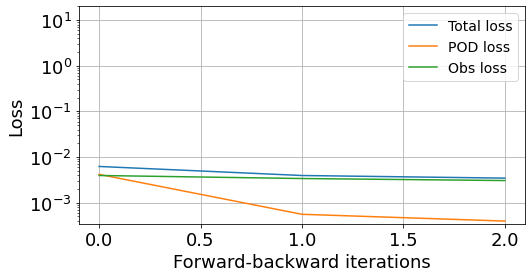

In [ ]:
loss = (np.array(backward_loss)+np.array(forward_loss))/2
new_loss = loss.copy()

# Because we discard the forward-backward iteration with loss greater than the minimum
print(0, new_loss[0,:])
for i in range(1,len(new_loss)):
    if new_loss[i,-1] > new_loss[i-1,-1]:
        new_loss[i,:] = new_loss[i-1,:] 
    print(i, new_loss[i,:])
    
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(new_loss)
ax.set_yscale('log')
ax.set_ylim(top=2*10**1)
ax.set_ylabel('Loss') 
ax.set_xlabel('Forward-backward iterations')   
plt.grid()
plt.legend(['Total loss','POD loss','Obs loss'])

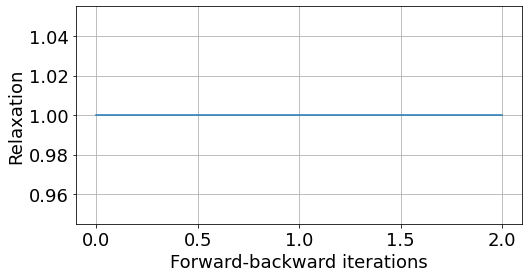

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(list_relax)
ax.set_ylabel('Relaxation') 
ax.set_xlabel('Forward-backward iterations')   
plt.grid()

In [ ]:
times = [i for i in range(len(X_predict_forward))]
plot_vortex(generated_forward, times, cols=len(times), c_bar=False, sensor_loc=grid_sensor)

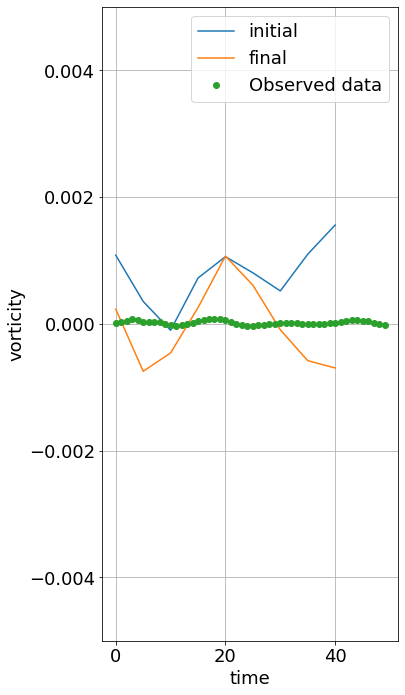

In [134]:
plot_obs_data(gen_X_predict_forward_first, gen_X_predict_forward_last, 25, 75, obs_times, X_obs[obs_times], grid_points)